# Петър и вълкът: Въведение в Укрепващото Обучение

В този урок ще научим как да приложим Укрепващо обучение към задача за намиране на път. Сценарият е вдъхновен от музикалната приказка [Петър и вълкът](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) на руския композитор [Сергей Прокофиев](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Това е история за младия пионер Петър, който смело излиза от дома си към горската поляна, за да преследва вълка. Ще обучим алгоритми за машинно обучение, които ще помогнат на Петър да изследва околността и да създаде оптимална карта за навигация.

Първо, нека импортираме няколко полезни библиотеки:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Преглед на Укрепващото Обучение

**Укрепващото Обучение** (RL) е техника за обучение, която ни позволява да научим оптималното поведение на **агент** в дадена **среда**, като провеждаме множество експерименти. Агентът в тази среда трябва да има някаква **цел**, определена чрез **функция за награда**.

## Средата

За простота, нека разгледаме света на Петър като квадратна дъска с размери `width` x `height`. Всяка клетка на тази дъска може да бъде:
* **земя**, върху която Петър и други същества могат да ходят
* **вода**, върху която очевидно не може да се ходи
* **дърво** или **трева** - място, където можеш да си починеш
* **ябълка**, която представлява нещо, което Петър би се радвал да намери, за да се нахрани
* **вълк**, който е опасен и трябва да се избягва

За да работим със средата, ще дефинираме клас, наречен `Board`. За да не претоварваме този тетраден файл, сме преместили целия код за работа с дъската в отделен модул `rlboard`, който сега ще импортираме. Можете да разгледате този модул, за да получите повече подробности за вътрешната реализация.


In [2]:
from rlboard import *

Нека сега създадем произволна дъска и да видим как изглежда:


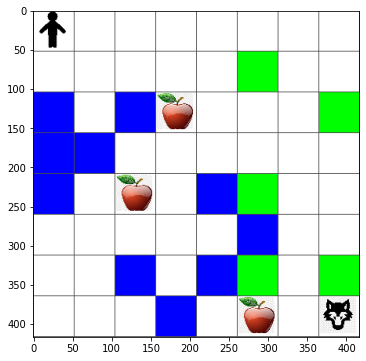

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Действия и Политика

В нашия пример целта на Петър е да намери ябълка, като избягва вълка и други препятствия. За да постигне това, той може просто да се разхожда, докато намери ябълка. Следователно, на всяка позиция той може да избере една от следните действия: нагоре, надолу, наляво и надясно. Ще дефинираме тези действия като речник и ще ги свържем с двойки от съответните промени в координатите. Например, движението надясно (`R`) би съответствало на двойка `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Стратегията на нашия агент (Петър) се определя от така наречената **политика**. Нека разгледаме най-простата политика, наречена **случайна разходка**.

## Случайна разходка

Нека първо решим нашия проблем, като приложим стратегията на случайна разходка.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Нека проведем експеримента със случайно движение няколко пъти и видим средния брой направени стъпки:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Функция за възнаграждение

За да направим нашата политика по-интелигентна, трябва да разберем кои ходове са "по-добри" от останалите.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Създайте Q-таблица или многомерен масив. Тъй като нашата дъска има размери `width` x `height`, можем да представим Q-таблицата чрез numpy масив с форма `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Предайте Q-таблицата на функцията за визуализация, за да я изобразите на дъската:


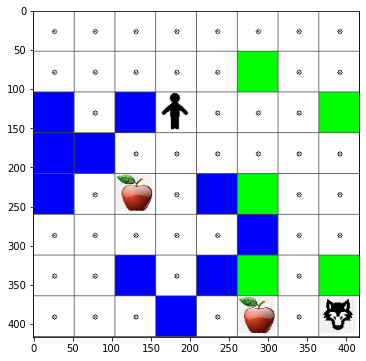

In [9]:
m.plot(Q)

## Същност на Q-Learning: Уравнение на Белман и алгоритъм за обучение

Напишете псевдокод за нашия алгоритъм за обучение:

* Инициализирайте Q-таблицата Q с равни стойности за всички състояния и действия
* Задайте скорост на обучение $\alpha\leftarrow 1$
* Повтаряйте симулацията многократно
   1. Започнете от случайна позиция
   1. Повтаряйте
        1. Изберете действие $a$ в състояние $s$
        2. Изпълнете действието, като преминете към ново състояние $s'$
        3. Ако срещнем условие за край на играта или общата награда е твърде малка - прекратете симулацията  
        4. Изчислете наградата $r$ в новото състояние
        5. Актуализирайте Q-функцията според уравнението на Белман: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Актуализирайте общата награда и намалете $\alpha$.

## Експлоатация срещу изследване

Най-добрият подход е да се балансира между изследване и експлоатация. Докато научаваме повече за нашата среда, е по-вероятно да следваме оптималния маршрут, но е важно понякога да избираме неизследван път.

## Имплементация на Python

Сега сме готови да имплементираме алгоритъма за обучение. Преди това ни е необходима функция, която ще преобразува произволни числа в Q-таблицата във вектор от вероятности за съответните действия:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Добавяме малко количество `eps` към оригиналния вектор, за да избегнем деление на 0 в началния случай, когато всички компоненти на вектора са идентични.

Същинският алгоритъм за обучение ще изпълним за 5000 експеримента, наричани също **епохи**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

След изпълнението на този алгоритъм, Q-таблицата трябва да бъде актуализирана със стойности, които определят привлекателността на различните действия на всяка стъпка. Визуализирайте таблицата тук:


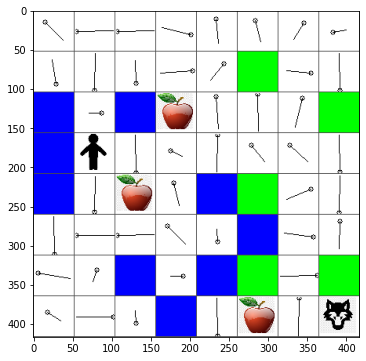

In [12]:
m.plot(Q)

## Проверка на политиката

Тъй като Q-таблицата изброява "привлекателността" на всяко действие във всяко състояние, е доста лесно да я използваме, за да определим ефективната навигация в нашия свят. В най-простия случай можем просто да изберем действието, което съответства на най-високата стойност в Q-таблицата:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Ако опитате кода по-горе няколко пъти, може да забележите, че понякога просто "забива" и трябва да натиснете бутона STOP в тетрадката, за да го прекъснете.

> **Задача 1:** Променете функцията `walk`, така че да ограничи максималната дължина на пътя до определен брой стъпки (например, 100), и наблюдавайте как кодът по-горе връща тази стойност от време на време.

> **Задача 2:** Променете функцията `walk`, така че да не се връща на места, където вече е бил преди. Това ще предотврати "зациклянето" на `walk`, но агентът все пак може да се окаже "заклещен" на място, от което не може да избяга.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


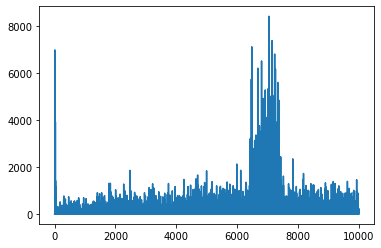

In [15]:
plt.plot(lpath)

Това, което виждаме тук, е, че в началото средната дължина на пътя се увеличава. Това вероятно се дължи на факта, че когато не знаем нищо за средата, сме склонни да попаднем в лоши състояния, като вода или вълк. С напредването на обучението и използването на натрупаните знания можем да изследваме средата за по-дълго време, но все още не знаем добре къде се намират ябълките.

След като научим достатъчно, става по-лесно за агента да постигне целта, и дължината на пътя започва да намалява. Въпреки това, все още сме отворени към изследване, което често ни отклонява от най-добрия път и ни кара да изпробваме нови опции, удължавайки пътя повече от оптималното.

Това, което също наблюдаваме на този график, е, че в даден момент дължината рязко се увеличава. Това показва стохастичния характер на процеса и че в определен момент можем да "развалим" коефициентите в Q-таблицата, като ги презапишем с нови стойности. Това трябва да бъде сведено до минимум чрез намаляване на скоростта на обучение (т.е. към края на обучението коригираме стойностите в Q-таблицата само с малки промени).

Като цяло е важно да запомним, че успехът и качеството на процеса на обучение значително зависят от параметри като скорост на обучение, намаляване на скоростта на обучение и коефициент на дисконтиране. Тези параметри често се наричат **хиперпараметри**, за да се разграничат от **параметрите**, които оптимизираме по време на обучението (например коефициентите в Q-таблицата). Процесът на намиране на най-добрите стойности за хиперпараметрите се нарича **оптимизация на хиперпараметри** и заслужава отделна тема.


## Упражнение
#### По-реалистичен свят на "Петя и вълкът"

В нашата ситуация Петя можеше да се движи почти без да се уморява или огладнява. В по-реалистичен свят той трябва да сяда и да си почива от време на време, както и да се храни. Нека направим нашия свят по-реалистичен, като приложим следните правила:

1. При движение от едно място на друго Петя губи **енергия** и натрупва **умора**.
2. Петя може да възстанови енергия, като яде ябълки.
3. Петя може да се освободи от умора, като си почива под дърво или на тревата (т.е. като се придвижи до поле с дърво или трева - зелено поле).
4. Петя трябва да намери и да убие вълка.
5. За да убие вълка, Петя трябва да има определени нива на енергия и умора, в противен случай губи битката.

Модифицирайте функцията за награда според правилата на играта, изпълнете алгоритъма за обучение чрез подсилване, за да научите най-добрата стратегия за спечелване на играта, и сравнете резултатите от случайното движение с вашия алгоритъм по отношение на броя на спечелените и загубените игри.

> **Note**: Може да се наложи да коригирате хиперпараметрите, за да работи, особено броя на епохите. Тъй като успехът в играта (битката с вълка) е рядко събитие, можете да очаквате значително по-дълго време за обучение.



---

**Отказ от отговорност**:  
Този документ е преведен с помощта на AI услуга за превод [Co-op Translator](https://github.com/Azure/co-op-translator). Въпреки че се стремим към точност, моля, имайте предвид, че автоматичните преводи може да съдържат грешки или неточности. Оригиналният документ на неговия изходен език трябва да се счита за авторитетен източник. За критична информация се препоръчва професионален превод от човек. Ние не носим отговорност за каквито и да е недоразумения или погрешни интерпретации, произтичащи от използването на този превод.
